In [1]:
###借鉴https://www.kaggle.com/code/sdelecourt/cnn-with-pytorch-for-mnist
# 多层感知机+MNIST数据集
#第二讲里面我们研究ReLU，GELU， SiLU， RayLU这样的输出在x>0区域无界的激活函数

In [2]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('D:/2023年研究生文件/mnist_train.csv')
#可以从这里下载https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?resource=download
# 或者这里https://github.com/sbussmann/kaggle-mnist/blob/master/Data/train.csv
#大约18M的手写字符数据库，不大。D:/贝叶斯优化与噪声注入改成自己的目录
print(df.shape)


(60000, 785)


In [5]:
y = df['label'].values#取标签
X = df.drop(['label'], axis=1).values#取图像
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#分割，按照80%训练，20%测试
print(y_test.shape)#测试数据60000*20%，训练数据80%

(12000,)


In [10]:
BATCH_SIZE = 100
##batch的大小，以及分批载入训练和测试数据到loader
torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [11]:
######sigmoid多层感知机
class MLPReLU(nn.Module):
    def __init__(self):
        super(MLPReLU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X.float()))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X
mlprelu = MLPReLU()
print(mlprelu)
# ######################
# ##这个感知机是全连接，有两层ReLU激活函数

MLPReLU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
)


In [12]:
optimizer = torch.optim.Adam(mlprelu.parameters())#,Adam优化学习器 lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listrelu = torch.zeros(EPOCHS)

for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlprelu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listrelu[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

# 定义评估函数
def evaluate(model, test_dataset):
    correct = 0
    total_samples = len(test_dataset)
    model.eval()
    with torch.no_grad():
        for test_imgs, test_labels in test_dataset:
            test_imgs = test_imgs.float()  # 将输入数据类型转换为 Float
            output = model(test_imgs.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            correct += (predicted == test_labels).item()
    accuracy = correct / total_samples * 100
    print("Test accuracy: {:.3f}%".format(accuracy))

# 评估模型
evaluate(mlprelu, test)

Epoch : 1 	Accuracy:77.685%
Epoch : 2 	Accuracy:90.715%
Epoch : 3 	Accuracy:92.477%
Epoch : 4 	Accuracy:93.360%
Epoch : 5 	Accuracy:93.958%
Epoch : 6 	Accuracy:94.327%
Epoch : 7 	Accuracy:94.554%
Epoch : 8 	Accuracy:94.808%
Epoch : 9 	Accuracy:94.890%
Epoch : 10 	Accuracy:95.079%
Epoch : 11 	Accuracy:95.250%
Epoch : 12 	Accuracy:95.308%
Epoch : 13 	Accuracy:95.485%
Epoch : 14 	Accuracy:95.544%
Epoch : 15 	Accuracy:95.598%
Epoch : 16 	Accuracy:95.702%
Epoch : 17 	Accuracy:95.792%
Epoch : 18 	Accuracy:95.852%
Epoch : 19 	Accuracy:95.821%
Epoch : 20 	Accuracy:95.931%
Test accuracy: 93.442%


In [13]:
frame = pd.DataFrame(correct_listsigmoid)
frame.to_csv('D:/2023年研究生文件/ReLU_train.csv', index=False)
#把训练精度correct_listsigmoid存到csv文件，后面画图可以调出

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
##为了更加详细看看每个数字的测试精度，召回率，F1-score，我们可以用混淆矩阵来看这个模型
# 将模型设置为评估模式
mlprelu.eval()
# 初始化变量来存储所有预测结果和真实标签
all_predictions = []
all_targets = []
# 在测试集上进行预测
with torch.no_grad():
    for images, labels in test_loader:
        outputs = mlprelu(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

all_targets = torch.tensor(all_targets).float()
# 计算混淆矩阵
conf_matrix = confusion_matrix(all_targets, all_predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(conf_matrix)

# 计算并打印分类报告（包括精确度、召回率、F1值等）
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions))
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 绘制混淆矩阵的热力图，如果需要的话
# def plot_confusion_matrix(conf_matrix):
#     plt.figure(figsize=(8, 6))
#     sns.set(font_scale=1.2)  # 设置字体大小
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

# # 调用函数绘制混淆矩阵
# plot_confusion_matrix(conf_matrix)

Confusion Matrix:
[[1136    0    2    0    2   25   12    1    8    4]
 [   0 1322   14    4    0    0    3   10    7    2]
 [  11    2 1067   17   12    7   13   19   20    3]
 [   3    3   31 1089    2   36    2   33   42   10]
 [   5    3    2    0 1092    4    7   18    4   51]
 [   6    3    5   19    1 1026   12    3   21   13]
 [   4    1    1    0    4   14 1117    0    7    0]
 [   3    0   15    2    7    1    0 1199    7    7]
 [   5    8   17    1    2   18   15    2 1083    7]
 [   3    1    0    4   27    9    2   40   16 1082]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1190
         1.0       0.98      0.97      0.98      1362
         2.0       0.92      0.91      0.92      1171
         3.0       0.96      0.87      0.91      1251
         4.0       0.95      0.92      0.94      1186
         5.0       0.90      0.93      0.91      1109
         6.0       0.94      0.97      0.96     

In [15]:
###从上面可以看出每个数字的测试精度，召回率，F1-score

In [17]:
##########高斯误差线性激活函数
##########x*(1-F(-x))，取F为高斯累积分布函数，这里是x*GEU,那么每层含有一个学习参数sigma1，sigma2

import math
class GELU(nn.Module):
    def __init__(self, init_sigma=3.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma))  # 将 sigma=3.0是浮点数，3是整型
    
    def forward(self, input):
        output = input*(1+torch.erf(input/math.sqrt(2)/self.sigma))/2 ###x*(1-F(-x))，取F为高斯累积分布函数
        return output
##########################################
class MLPGELU(nn.Module):
    def __init__(self, init_sigma=3.0):
        super(MLPGELU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.gelu1 = GELU(init_sigma=init_sigma)  # 初始化 GELU 层时传入初始 sigma 值
        self.gelu2 = GELU(init_sigma=init_sigma)
    
    def forward(self,X):
        X = self.gelu1(self.linear1(X))
        X = self.gelu2(self.linear2(X))
        X = self.linear3(X)
        return X

mlpgelu = MLPGELU()
print(mlpgelu)
###############
optimizer = torch.optim.Adam(mlpgelu.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listGELU = torch.zeros(EPOCHS)
learnsigma1 = torch.zeros(EPOCHS) ##存储sigma学习值
learnsigma2 = torch.zeros(EPOCHS)


for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0

    learnsigma1[epoch] = mlpgelu.gelu1.sigma.data
    learnsigma2[epoch] = mlpgelu.gelu2.sigma.data
    #放在循环前面就是把初值3.0记住，放后面第一个值是已经更新了
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlpgelu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listGELU[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

evaluate(mlpgelu, test)###测试精度

MLPGELU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (gelu1): GELU()
  (gelu2): GELU()
)
Epoch : 1 	Accuracy:81.369%
Epoch : 2 	Accuracy:91.158%
Epoch : 3 	Accuracy:92.740%
Epoch : 4 	Accuracy:93.569%
Epoch : 5 	Accuracy:94.094%
Epoch : 6 	Accuracy:94.473%
Epoch : 7 	Accuracy:94.827%
Epoch : 8 	Accuracy:94.994%
Epoch : 9 	Accuracy:95.200%
Epoch : 10 	Accuracy:95.398%
Epoch : 11 	Accuracy:95.567%
Epoch : 12 	Accuracy:95.642%
Epoch : 13 	Accuracy:95.723%
Epoch : 14 	Accuracy:95.850%
Epoch : 15 	Accuracy:95.944%
Epoch : 16 	Accuracy:95.921%
Epoch : 17 	Accuracy:96.098%
Epoch : 18 	Accuracy:96.027%
Epoch : 19 	Accuracy:96.183%
Epoch : 20 	Accuracy:96.102%
Test accuracy: 93.892%


In [21]:
####可以看出GELU比ReLU，训练精度从95.931%提高到96.102%，测试精度也没有提高多少

##GELU的初值
print(learnsigma1)
print(learnsigma2)

tensor([3.0000, 2.8830, 2.7950, 2.7363, 2.6684, 2.5998, 2.5221, 2.4612, 2.4069,
        2.3385, 2.2911, 2.2365, 2.1887, 2.1491, 2.1155, 2.0856, 2.0301, 2.0138,
        2.0097, 1.9787])
tensor([3.0000, 2.9420, 2.8594, 2.8135, 2.7519, 2.6825, 2.6138, 2.5617, 2.5016,
        2.4314, 2.3687, 2.3288, 2.2884, 2.2400, 2.1983, 2.1723, 2.1207, 2.0967,
        2.0581, 1.9970])


In [27]:
#sigma1,sigma2的初值选取影响大吗？取初值为5
##########################################
class MLPGELU(nn.Module):
    def __init__(self, init_sigma=3.5):
        super(MLPGELU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.gelu1 = GELU(init_sigma=init_sigma)  # 初始化 GELU 层时传入初始 sigma 值
        self.gelu2 = GELU(init_sigma=init_sigma)
    
    def forward(self,X):
        X = self.gelu1(self.linear1(X))
        X = self.gelu2(self.linear2(X))
        X = self.linear3(X)
        return X

mlpgelu = MLPGELU()
print(mlpgelu)
###############
optimizer = torch.optim.Adam(mlpgelu.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listGELU = torch.zeros(EPOCHS)
learnsigma1 = torch.zeros(EPOCHS) ##存储sigma学习值
learnsigma2 = torch.zeros(EPOCHS)


for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0

    learnsigma1[epoch] = mlpgelu.gelu1.sigma.data
    learnsigma2[epoch] = mlpgelu.gelu2.sigma.data
    #放在循环前面就是把初值3.0记住，放后面第一个值是已经更新了
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlpgelu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listGELU[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

evaluate(mlpgelu, test)###测试精度

MLPGELU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (gelu1): GELU()
  (gelu2): GELU()
)
Epoch : 1 	Accuracy:74.746%
Epoch : 2 	Accuracy:88.277%
Epoch : 3 	Accuracy:90.035%
Epoch : 4 	Accuracy:90.910%
Epoch : 5 	Accuracy:91.904%
Epoch : 6 	Accuracy:92.562%
Epoch : 7 	Accuracy:93.188%
Epoch : 8 	Accuracy:93.433%
Epoch : 9 	Accuracy:93.600%
Epoch : 10 	Accuracy:93.823%
Epoch : 11 	Accuracy:93.912%
Epoch : 12 	Accuracy:94.102%
Epoch : 13 	Accuracy:94.260%
Epoch : 14 	Accuracy:94.300%
Epoch : 15 	Accuracy:94.415%
Epoch : 16 	Accuracy:94.552%
Epoch : 17 	Accuracy:94.631%
Epoch : 18 	Accuracy:94.819%
Epoch : 19 	Accuracy:94.873%
Epoch : 20 	Accuracy:94.863%
Test accuracy: 93.208%


In [34]:
#即使改变sigma初值，变化也不大，因为我们总是设置全部一个初值开始，sigma1，2应该不同的初值开始可能更好
#在使用optuna之前，我们试试其他激活函数，因为#x*(1-F(-x))，取F为高斯累积分布函数，逻辑，Rayleigh等分布，给出不同的激活函数
#SiLU, RayLU,ExLU
class SiLU(nn.Module):
    def __init__(self, init_sigma=2.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma))  # 将 sigma=3.0是浮点数，3是整型
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma) ###x*(1-F(-x))，取F为Logostic分布函数
        return output
##########################################
class MLPSiLU(nn.Module):
    def __init__(self, init_sigma=2.0):
        super(MLPSiLU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.silu1 = SiLU(init_sigma=init_sigma)  # 初始化 SiLU 层时传入初始 sigma 值
        self.silu2 = SiLU(init_sigma=init_sigma)
    
    def forward(self,X):
        X = self.silu1(self.linear1(X))
        X = self.silu2(self.linear2(X))
        X = self.linear3(X)
        return X

mlpsilu = MLPSiLU()
print(mlpsilu)
###############
optimizer = torch.optim.Adam(mlpsilu.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listSiLU = torch.zeros(EPOCHS)
learnsigma1 = torch.zeros(EPOCHS) ##存储sigma学习值
learnsigma2 = torch.zeros(EPOCHS)


for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0

    learnsigma1[epoch] = mlpsilu.silu1.sigma.data
    learnsigma2[epoch] = mlpsilu.silu2.sigma.data
    #放在循环前面就是把初值3.0记住，放后面第一个值是已经更新了
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlpsilu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listSiLU[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

evaluate(mlpsilu, test)###测试精度

MLPSiLU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (silu1): SiLU()
  (silu2): SiLU()
)
Epoch : 1 	Accuracy:70.050%
Epoch : 2 	Accuracy:88.052%
Epoch : 3 	Accuracy:89.940%
Epoch : 4 	Accuracy:90.542%
Epoch : 5 	Accuracy:90.877%
Epoch : 6 	Accuracy:91.235%
Epoch : 7 	Accuracy:91.565%
Epoch : 8 	Accuracy:91.763%
Epoch : 9 	Accuracy:91.850%
Epoch : 10 	Accuracy:91.992%
Epoch : 11 	Accuracy:92.038%
Epoch : 12 	Accuracy:92.150%
Epoch : 13 	Accuracy:92.106%
Epoch : 14 	Accuracy:92.271%
Epoch : 15 	Accuracy:92.373%
Epoch : 16 	Accuracy:92.342%
Epoch : 17 	Accuracy:92.619%
Epoch : 18 	Accuracy:92.810%
Epoch : 19 	Accuracy:93.060%
Epoch : 20 	Accuracy:93.200%
Test accuracy: 91.508%


In [37]:
#SiLU, RayLU,ExLU
class RayLU(nn.Module):
    def __init__(self, init_sigma=5.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(RayLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma))  # 将 sigma=3.0是浮点数，3是整型
    
    def forward(self, input):
        output = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2)) ###x*(1-F(-x))，取F为Logostic分布函数
        return output
##########################################
class MLPRayLU(nn.Module):
    def __init__(self, init_sigma=5.0):
        super(MLPRayLU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.raylu1 = RayLU(init_sigma=init_sigma)  # 初始化 SiLU 层时传入初始 sigma 值
        self.raylu2 = RayLU(init_sigma=init_sigma)
    
    def forward(self,X):
        X = self.raylu1(self.linear1(X))
        X = self.raylu2(self.linear2(X))
        X = self.linear3(X)
        return X

mlpraylu = MLPRayLU()
print(mlpraylu)
###############
optimizer = torch.optim.Adam(mlpraylu.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listRayLU = torch.zeros(EPOCHS)
learnsigma1 = torch.zeros(EPOCHS) ##存储sigma学习值
learnsigma2 = torch.zeros(EPOCHS)


for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0

    learnsigma1[epoch] = mlpraylu.raylu1.sigma.data
    learnsigma2[epoch] = mlpraylu.raylu2.sigma.data
    #放在循环前面就是把初值3.0记住，放后面第一个值是已经更新了
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlpraylu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listRayLU[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

evaluate(mlpraylu, test)###测试精度

MLPRayLU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (raylu1): RayLU()
  (raylu2): RayLU()
)
Epoch : 1 	Accuracy:70.254%
Epoch : 2 	Accuracy:87.721%
Epoch : 3 	Accuracy:90.708%
Epoch : 4 	Accuracy:91.992%
Epoch : 5 	Accuracy:92.831%
Epoch : 6 	Accuracy:93.135%
Epoch : 7 	Accuracy:93.469%
Epoch : 8 	Accuracy:93.763%
Epoch : 9 	Accuracy:93.840%
Epoch : 10 	Accuracy:94.027%
Epoch : 11 	Accuracy:94.158%
Epoch : 12 	Accuracy:94.285%
Epoch : 13 	Accuracy:94.440%
Epoch : 14 	Accuracy:94.544%
Epoch : 15 	Accuracy:94.590%
Epoch : 16 	Accuracy:94.696%
Epoch : 17 	Accuracy:94.810%
Epoch : 18 	Accuracy:94.842%
Epoch : 19 	Accuracy:94.967%
Epoch : 20 	Accuracy:94.919%
Test accuracy: 92.525%


In [39]:
#SiLU, RayLU,ExLU
class ExLU(nn.Module):
    def __init__(self, init_sigma=10.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(ExLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma))  # 将 sigma=3.0是浮点数，3是整型
    
    def forward(self, input):
        output = torch.where(input>=0, input, input*torch.exp(input/self.sigma)) 
        ###x*(1-F(-x))，取F为单边指数分布函数
        return output
##########################################
class MLPExLU(nn.Module):
    def __init__(self, init_sigma=10.0):
        super(MLPExLU, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.exlu1 = ExLU(init_sigma=init_sigma)  # 初始化 SiLU 层时传入初始 sigma 值
        self.exlu2 = ExLU(init_sigma=init_sigma)
    
    def forward(self,X):
        X = self.exlu1(self.linear1(X))
        X = self.exlu2(self.linear2(X))
        X = self.linear3(X)
        return X

mlpexlu = MLPExLU()
print(mlpexlu)
###############
optimizer = torch.optim.Adam(mlpexlu.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()
EPOCHS = 20
# 定义 correct_list 变量来存储每个 epoch 结束时的正确预测数量
correct_listExLU = torch.zeros(EPOCHS)
#learnsigma1 = torch.zeros(EPOCHS) ##存储sigma学习值
#learnsigma2 = torch.zeros(EPOCHS)


for epoch in range(EPOCHS):
    correct = 0
    ave_correct = 0

    #learnsigma1[epoch] = mlpexlu.exlu1.sigma.data
    #learnsigma2[epoch] = mlpexlu.exlu2.sigma.data
    #放在循环前面就是把初值3.0记住，放后面第一个值是已经更新了
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = mlpexlu(var_X_batch)
        loss = error(output, var_y_batch)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == var_y_batch).sum()
        
    ave_correct = float(correct) / len(train_loader.dataset) * 100

    correct_listExLU[epoch]=ave_correct

    if epoch % 1 == 0:
        print('Epoch : {} \tAccuracy:{:.3f}%'.format(epoch + 1, ave_correct))

evaluate(mlpexlu, test)###测试精度

MLPExLU(
  (linear1): Linear(in_features=784, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=10, bias=True)
  (exlu1): ExLU()
  (exlu2): ExLU()
)
Epoch : 1 	Accuracy:64.448%
Epoch : 2 	Accuracy:87.608%
Epoch : 3 	Accuracy:89.392%
Epoch : 4 	Accuracy:90.117%
Epoch : 5 	Accuracy:90.527%
Epoch : 6 	Accuracy:90.806%
Epoch : 7 	Accuracy:16.290%
Epoch : 8 	Accuracy:9.860%
Epoch : 9 	Accuracy:9.860%
Epoch : 10 	Accuracy:9.860%
Epoch : 11 	Accuracy:9.860%
Epoch : 12 	Accuracy:9.860%
Epoch : 13 	Accuracy:9.860%
Epoch : 14 	Accuracy:9.860%
Epoch : 15 	Accuracy:9.860%
Epoch : 16 	Accuracy:9.860%
Epoch : 17 	Accuracy:9.860%
Epoch : 18 	Accuracy:9.860%
Epoch : 19 	Accuracy:9.860%
Epoch : 20 	Accuracy:9.860%
Test accuracy: 9.917%


In [ ]:
#ExLU出现学习失败的状态。
###接下来我们试试optuna-贝叶斯优化方法，对于两个sigma值的优化能否进一步提高精度，召回率等
import optuna
class GELUB(nn.Module): #带参数的gelu激活函数
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma
#在这个字符串格式中，f-string 中的 {} 用于引用变量或表达式的值。在你提供的代码中，
#f'$\sigma_{seqFlag}$' 中的 {} 用于将 seqFlag 的值插入到字符串中，形成一个带有动态值的字符串
    def forward(self, input):
        x = input*(1+torch.erf(input/math.sqrt(2)/self.sigma))/2
        return x

In [ ]:
##########################################
class MLPGELUB(nn.Module):
    def __init__(self, trial):
        super(MLPGELUB, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.gelub1 = GELUB(1,trial)  # $\sigma_{seqFlag}$
        self.gelub2 = GELUB(2,trial)
    
    def forward(self,X):
        X = self.gelub1(self.linear1(X))
        X = self.gelub2(self.linear2(X))
        X = self.linear3(X)
        return X

In [ ]:
def objective(trial):
    # 定义模型
    mlpgelub = MLPGELUB(trial)  # 在这里传递 trial 对象给 GEU 类以动态设置参数
    #注意下面很多需要改mlpgeub模型名字，如果你换一个model
    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(mlpgelub.parameters())
    error = nn.CrossEntropyLoss()
    
    EPOCHS = 20
    
    for epoch in range(EPOCHS):
        correct = 0
        ave_correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = mlpgelub(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == var_y_batch).sum()

        ave_correct = float(correct) / len(train_loader.dataset) * 100


    # 打印最后一个 epoch 的准确率
    print('Epoch : {} \tAccuracy:{:.3f}%'.format(EPOCHS, ave_correct))

        # 在该模型上进行测试集评估
    correct_test = 0
    total_samples = len(test)
    mlpgelub.eval()
    with torch.no_grad():
        for test_imgs, test_labels in test:
            test_imgs = test_imgs.float()  # 将输入数据类型转换为 Float
            output = mlpgelub(test_imgs.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            correct_test += (predicted == test_labels).item()
    accuracy = correct_test / total_samples * 100
    # 返回目标值
    return accuracy

# 创建一个 Optuna study 对象
study = optuna.create_study(direction='maximize')

# 运行优化过程
study.optimize(objective, n_trials=100)

# 打印最佳参数和目标值
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-03-22 14:08:45,277] A new study created in memory with name: no-name-d6bba31f-aaff-4e30-80c7-871163e493d8


Epoch : 20 	Accuracy:95.185%


[I 2024-03-22 14:09:11,115] Trial 0 finished with value: 93.15 and parameters: {'$\\sigma_1$': 2.653848215940128, '$\\sigma_2$': 1.6305699985737199}. Best is trial 0 with value: 93.15.


Epoch : 20 	Accuracy:94.965%


[I 2024-03-22 14:09:36,096] Trial 1 finished with value: 92.99166666666666 and parameters: {'$\\sigma_1$': 0.6264018642605385, '$\\sigma_2$': 6.524296585504908}. Best is trial 0 with value: 93.15.


Epoch : 20 	Accuracy:95.188%


[I 2024-03-22 14:10:01,607] Trial 2 finished with value: 93.075 and parameters: {'$\\sigma_1$': 5.2671531495861235, '$\\sigma_2$': 5.060672594730921}. Best is trial 0 with value: 93.15.


Epoch : 20 	Accuracy:95.146%


[I 2024-03-22 14:10:26,640] Trial 3 finished with value: 93.16666666666666 and parameters: {'$\\sigma_1$': 2.5723536729630836, '$\\sigma_2$': 9.732989817440085}. Best is trial 3 with value: 93.16666666666666.


Epoch : 20 	Accuracy:95.835%


[I 2024-03-22 14:10:52,305] Trial 4 finished with value: 93.525 and parameters: {'$\\sigma_1$': 6.994752117369316, '$\\sigma_2$': 3.9198553029470693}. Best is trial 4 with value: 93.525.


Epoch : 20 	Accuracy:93.237%


[I 2024-03-22 14:11:18,390] Trial 5 finished with value: 90.64999999999999 and parameters: {'$\\sigma_1$': 6.217595928735351, '$\\sigma_2$': 3.136977197110461}. Best is trial 4 with value: 93.525.


Epoch : 20 	Accuracy:95.833%


[I 2024-03-22 14:11:43,111] Trial 6 finished with value: 93.72500000000001 and parameters: {'$\\sigma_1$': 0.21084725322710773, '$\\sigma_2$': 5.563166876490716}. Best is trial 6 with value: 93.72500000000001.


Epoch : 20 	Accuracy:97.200%


[I 2024-03-22 14:12:08,220] Trial 7 finished with value: 93.91666666666667 and parameters: {'$\\sigma_1$': 0.4666700282917391, '$\\sigma_2$': 1.4585175190290611}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:95.915%


[I 2024-03-22 14:12:33,632] Trial 8 finished with value: 93.25833333333333 and parameters: {'$\\sigma_1$': 2.2631230501642796, '$\\sigma_2$': 1.2650735797207002}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:95.917%


[I 2024-03-22 14:12:59,507] Trial 9 finished with value: 93.5 and parameters: {'$\\sigma_1$': 9.080003059931682, '$\\sigma_2$': 6.845168972571382}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:93.827%


[I 2024-03-22 14:13:25,728] Trial 10 finished with value: 92.025 and parameters: {'$\\sigma_1$': 3.892399571894557, '$\\sigma_2$': 0.40100749652132084}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:96.035%


[I 2024-03-22 14:13:51,023] Trial 11 finished with value: 93.89166666666667 and parameters: {'$\\sigma_1$': 0.3897326343283053, '$\\sigma_2$': 2.4977978855123752}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:95.256%


[I 2024-03-22 14:14:16,427] Trial 12 finished with value: 92.9 and parameters: {'$\\sigma_1$': 0.5326231948447934, '$\\sigma_2$': 2.5559662803536}. Best is trial 7 with value: 93.91666666666667.


Epoch : 20 	Accuracy:96.754%


[I 2024-03-22 14:14:41,695] Trial 13 finished with value: 94.74166666666667 and parameters: {'$\\sigma_1$': 1.5305622117822488, '$\\sigma_2$': 0.019223855445568372}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.219%


[I 2024-03-22 14:15:07,012] Trial 14 finished with value: 93.48333333333333 and parameters: {'$\\sigma_1$': 1.6103555656216306, '$\\sigma_2$': 0.23487743647091402}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.781%


[I 2024-03-22 14:15:32,996] Trial 15 finished with value: 93.99166666666666 and parameters: {'$\\sigma_1$': 4.0506604796750425, '$\\sigma_2$': 0.06856690668699075}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.935%


[I 2024-03-22 14:15:58,767] Trial 16 finished with value: 93.81666666666668 and parameters: {'$\\sigma_1$': 3.7386458436287837, '$\\sigma_2$': 0.18363832071899733}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.288%


[I 2024-03-22 14:16:24,400] Trial 17 finished with value: 93.26666666666667 and parameters: {'$\\sigma_1$': 3.847313256776495, '$\\sigma_2$': 0.10898760325556965}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.027%


[I 2024-03-22 14:16:50,102] Trial 18 finished with value: 93.525 and parameters: {'$\\sigma_1$': 1.5988626449107468, '$\\sigma_2$': 1.430776298020109}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.921%


[I 2024-03-22 14:17:16,102] Trial 19 finished with value: 93.22500000000001 and parameters: {'$\\sigma_1$': 4.862240423487971, '$\\sigma_2$': 2.6154817645645125}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.290%


[I 2024-03-22 14:17:41,406] Trial 20 finished with value: 93.01666666666667 and parameters: {'$\\sigma_1$': 3.4742434068926435, '$\\sigma_2$': 3.334642740439924}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.308%


[I 2024-03-22 14:18:06,718] Trial 21 finished with value: 94.5 and parameters: {'$\\sigma_1$': 1.734189600957902, '$\\sigma_2$': 1.2608053880729004}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.271%


[I 2024-03-22 14:18:31,982] Trial 22 finished with value: 94.325 and parameters: {'$\\sigma_1$': 1.6813534244196229, '$\\sigma_2$': 0.9003198074266208}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.865%


[I 2024-03-22 14:18:57,239] Trial 23 finished with value: 93.73333333333333 and parameters: {'$\\sigma_1$': 1.3000848501435933, '$\\sigma_2$': 0.9579755536946548}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.277%


[I 2024-03-22 14:19:22,901] Trial 24 finished with value: 92.5 and parameters: {'$\\sigma_1$': 1.8762991371232325, '$\\sigma_2$': 1.9808724815460401}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.250%


[I 2024-03-22 14:19:48,480] Trial 25 finished with value: 93.925 and parameters: {'$\\sigma_1$': 2.8484288244973177, '$\\sigma_2$': 0.873419539272035}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.731%


[I 2024-03-22 14:20:14,126] Trial 26 finished with value: 93.96666666666667 and parameters: {'$\\sigma_1$': 1.52054049837448, '$\\sigma_2$': 0.903098861076933}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.560%


[I 2024-03-22 14:20:39,576] Trial 27 finished with value: 92.475 and parameters: {'$\\sigma_1$': 1.0924009982255094, '$\\sigma_2$': 0.7171341992204097}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.506%


[I 2024-03-22 14:21:04,826] Trial 28 finished with value: 94.40833333333333 and parameters: {'$\\sigma_1$': 2.253217219283841, '$\\sigma_2$': 1.9126115161102275}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.688%


[I 2024-03-22 14:21:30,497] Trial 29 finished with value: 93.60833333333333 and parameters: {'$\\sigma_1$': 2.650161583272255, '$\\sigma_2$': 1.893703565609608}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.773%


[I 2024-03-22 14:21:56,218] Trial 30 finished with value: 93.65833333333333 and parameters: {'$\\sigma_1$': 2.8960940681030714, '$\\sigma_2$': 1.877424385841934}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.965%


[I 2024-03-22 14:22:21,669] Trial 31 finished with value: 93.125 and parameters: {'$\\sigma_1$': 1.058143692453487, '$\\sigma_2$': 1.2231171843431379}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.210%


[I 2024-03-22 14:22:47,288] Trial 32 finished with value: 92.39166666666667 and parameters: {'$\\sigma_1$': 2.044019477440323, '$\\sigma_2$': 0.8074146455340916}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.671%


[I 2024-03-22 14:23:12,688] Trial 33 finished with value: 93.46666666666667 and parameters: {'$\\sigma_1$': 2.0670912165449895, '$\\sigma_2$': 1.7898169938981758}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.004%


[I 2024-03-22 14:23:38,147] Trial 34 finished with value: 92.73333333333333 and parameters: {'$\\sigma_1$': 1.079577363324572, '$\\sigma_2$': 0.017126493568913007}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.556%


[I 2024-03-22 14:24:03,376] Trial 35 finished with value: 93.30833333333334 and parameters: {'$\\sigma_1$': 0.11068792547520023, '$\\sigma_2$': 1.3984708665639525}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.358%


[I 2024-03-22 14:24:29,073] Trial 36 finished with value: 93.72500000000001 and parameters: {'$\\sigma_1$': 3.067552395221317, '$\\sigma_2$': 0.720048778737939}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.202%


[I 2024-03-22 14:24:54,471] Trial 37 finished with value: 93.95 and parameters: {'$\\sigma_1$': 2.357285673807543, '$\\sigma_2$': 2.2909817578814975}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.877%


[I 2024-03-22 14:25:19,888] Trial 38 finished with value: 93.13333333333334 and parameters: {'$\\sigma_1$': 1.1062145934250331, '$\\sigma_2$': 4.218904173727314}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.604%


[I 2024-03-22 14:25:45,151] Trial 39 finished with value: 93.53333333333333 and parameters: {'$\\sigma_1$': 0.8169836193138369, '$\\sigma_2$': 3.1405616820781432}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.346%


[I 2024-03-22 14:26:11,055] Trial 40 finished with value: 93.72500000000001 and parameters: {'$\\sigma_1$': 2.402652572879938, '$\\sigma_2$': 1.5317495931182268}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.060%


[I 2024-03-22 14:26:36,580] Trial 41 finished with value: 93.38333333333333 and parameters: {'$\\sigma_1$': 1.6726383271739254, '$\\sigma_2$': 0.4372280021584622}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.692%


[I 2024-03-22 14:27:02,059] Trial 42 finished with value: 92.76666666666667 and parameters: {'$\\sigma_1$': 3.251194116054573, '$\\sigma_2$': 0.027411791768089104}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.335%


[I 2024-03-22 14:27:27,254] Trial 43 finished with value: 93.425 and parameters: {'$\\sigma_1$': 2.1270058949248787, '$\\sigma_2$': 1.087007255276968}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.142%


[I 2024-03-22 14:27:52,663] Trial 44 finished with value: 91.45 and parameters: {'$\\sigma_1$': 4.379457365913585, '$\\sigma_2$': 0.44701383886925106}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.848%


[I 2024-03-22 14:28:18,231] Trial 45 finished with value: 93.31666666666666 and parameters: {'$\\sigma_1$': 2.605289674206177, '$\\sigma_2$': 1.2913446544408274}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:93.938%


[I 2024-03-22 14:28:43,279] Trial 46 finished with value: 92.03333333333333 and parameters: {'$\\sigma_1$': 0.6946098685522545, '$\\sigma_2$': 0.5225455189083841}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.608%


[I 2024-03-22 14:29:08,500] Trial 47 finished with value: 92.86666666666666 and parameters: {'$\\sigma_1$': 0.013482539239021873, '$\\sigma_2$': 0.002789384837029951}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.773%


[I 2024-03-22 14:29:33,708] Trial 48 finished with value: 93.30000000000001 and parameters: {'$\\sigma_1$': 3.485466544228524, '$\\sigma_2$': 2.1783739243430174}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.112%


[I 2024-03-22 14:29:59,002] Trial 49 finished with value: 93.475 and parameters: {'$\\sigma_1$': 1.929394598669061, '$\\sigma_2$': 1.6189075757521278}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.183%


[I 2024-03-22 14:30:24,269] Trial 50 finished with value: 93.30000000000001 and parameters: {'$\\sigma_1$': 3.049394283776828, '$\\sigma_2$': 0.5807881902464709}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:92.925%


[I 2024-03-22 14:30:49,582] Trial 51 finished with value: 91.5 and parameters: {'$\\sigma_1$': 1.4312178964183822, '$\\sigma_2$': 0.9906174324170745}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:93.410%


[I 2024-03-22 14:31:15,297] Trial 52 finished with value: 92.225 and parameters: {'$\\sigma_1$': 1.6808639079735888, '$\\sigma_2$': 1.0717305963110828}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.915%


[I 2024-03-22 14:31:40,406] Trial 53 finished with value: 92.39166666666667 and parameters: {'$\\sigma_1$': 2.3403490910530476, '$\\sigma_2$': 0.40276276394275495}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.498%


[I 2024-03-22 14:32:05,740] Trial 54 finished with value: 92.61666666666667 and parameters: {'$\\sigma_1$': 0.6105637272955711, '$\\sigma_2$': 1.4368209215321883}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.879%


[I 2024-03-22 14:32:31,028] Trial 55 finished with value: 93.77499999999999 and parameters: {'$\\sigma_1$': 1.4858573512697375, '$\\sigma_2$': 2.5608568944920465}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:93.933%


[I 2024-03-22 14:32:56,597] Trial 56 finished with value: 92.25833333333333 and parameters: {'$\\sigma_1$': 2.5549242219370494, '$\\sigma_2$': 0.6999898072592204}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.925%


[I 2024-03-22 14:33:21,953] Trial 57 finished with value: 93.60000000000001 and parameters: {'$\\sigma_1$': 0.30466927291173307, '$\\sigma_2$': 0.9765494869562245}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.319%


[I 2024-03-22 14:33:47,260] Trial 58 finished with value: 93.61666666666667 and parameters: {'$\\sigma_1$': 1.500679233493073, '$\\sigma_2$': 1.730787248629581}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.052%


[I 2024-03-22 14:34:12,274] Trial 59 finished with value: 94.51666666666667 and parameters: {'$\\sigma_1$': 1.821817522354457, '$\\sigma_2$': 0.4173559536047129}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.679%


[I 2024-03-22 14:34:37,640] Trial 60 finished with value: 94.3 and parameters: {'$\\sigma_1$': 4.11949768844585, '$\\sigma_2$': 0.297069022821334}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.508%


[I 2024-03-22 14:35:03,451] Trial 61 finished with value: 93.98333333333333 and parameters: {'$\\sigma_1$': 5.122114610512426, '$\\sigma_2$': 0.4840626024652767}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.200%


[I 2024-03-22 14:35:28,965] Trial 62 finished with value: 94.325 and parameters: {'$\\sigma_1$': 4.1255221460535605, '$\\sigma_2$': 0.34919995623406286}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.444%


[I 2024-03-22 14:35:54,816] Trial 63 finished with value: 92.475 and parameters: {'$\\sigma_1$': 4.3931758567594725, '$\\sigma_2$': 0.32236229687829915}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.842%


[I 2024-03-22 14:36:20,017] Trial 64 finished with value: 93.74166666666667 and parameters: {'$\\sigma_1$': 5.53665334981607, '$\\sigma_2$': 0.26839094482655984}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.358%


[I 2024-03-22 14:36:45,620] Trial 65 finished with value: 93.84166666666667 and parameters: {'$\\sigma_1$': 1.9176285793158194, '$\\sigma_2$': 1.198826794303234}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.419%


[I 2024-03-22 14:37:11,279] Trial 66 finished with value: 93.525 and parameters: {'$\\sigma_1$': 3.4571418722353764, '$\\sigma_2$': 0.6485483068186031}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.315%


[I 2024-03-22 14:37:37,207] Trial 67 finished with value: 92.55833333333334 and parameters: {'$\\sigma_1$': 2.8321504986279926, '$\\sigma_2$': 1.6079574373728942}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.471%


[I 2024-03-22 14:38:02,617] Trial 68 finished with value: 92.72500000000001 and parameters: {'$\\sigma_1$': 2.25370204203791, '$\\sigma_2$': 0.8301587854749237}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.865%


[I 2024-03-22 14:38:27,846] Trial 69 finished with value: 94.35 and parameters: {'$\\sigma_1$': 1.198153913196411, '$\\sigma_2$': 2.095141108711403}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.625%


[I 2024-03-22 14:38:53,048] Trial 70 finished with value: 93.35833333333333 and parameters: {'$\\sigma_1$': 0.874423424468753, '$\\sigma_2$': 2.1181996578054587}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.604%


[I 2024-03-22 14:39:18,468] Trial 71 finished with value: 94.15 and parameters: {'$\\sigma_1$': 1.1267735799984415, '$\\sigma_2$': 1.1625210500482308}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.698%


[I 2024-03-22 14:39:44,163] Trial 72 finished with value: 93.425 and parameters: {'$\\sigma_1$': 1.776411236750726, '$\\sigma_2$': 0.3000550092947911}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.556%


[I 2024-03-22 14:40:09,680] Trial 73 finished with value: 93.46666666666667 and parameters: {'$\\sigma_1$': 1.358034428359828, '$\\sigma_2$': 1.9281954851299965}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.627%


[I 2024-03-22 14:40:34,982] Trial 74 finished with value: 93.55 and parameters: {'$\\sigma_1$': 0.4401926122668749, '$\\sigma_2$': 1.4353379997529576}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.042%


[I 2024-03-22 14:41:00,664] Trial 75 finished with value: 93.69166666666666 and parameters: {'$\\sigma_1$': 1.9874466146314325, '$\\sigma_2$': 0.7311368307886048}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.921%


[I 2024-03-22 14:41:25,968] Trial 76 finished with value: 93.65833333333333 and parameters: {'$\\sigma_1$': 2.703468879334744, '$\\sigma_2$': 0.1738316436801679}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.808%


[I 2024-03-22 14:41:51,403] Trial 77 finished with value: 93.64166666666667 and parameters: {'$\\sigma_1$': 1.2431214877911358, '$\\sigma_2$': 0.9737450809396563}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:92.650%


[I 2024-03-22 14:42:17,081] Trial 78 finished with value: 91.65833333333333 and parameters: {'$\\sigma_1$': 2.4691011019614804, '$\\sigma_2$': 1.209523200177181}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.817%


[I 2024-03-22 14:42:42,528] Trial 79 finished with value: 94.20833333333334 and parameters: {'$\\sigma_1$': 0.9535310227101528, '$\\sigma_2$': 1.7554623420233741}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.752%


[I 2024-03-22 14:43:09,032] Trial 80 finished with value: 93.4 and parameters: {'$\\sigma_1$': 2.187926527973457, '$\\sigma_2$': 0.0017197450145066268}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.912%


[I 2024-03-22 14:43:34,556] Trial 81 finished with value: 93.50833333333334 and parameters: {'$\\sigma_1$': 0.918430643732552, '$\\sigma_2$': 1.5985364386414358}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.127%


[I 2024-03-22 14:44:00,060] Trial 82 finished with value: 92.9 and parameters: {'$\\sigma_1$': 0.7003191180795489, '$\\sigma_2$': 2.3735210670040585}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.902%


[I 2024-03-22 14:44:25,513] Trial 83 finished with value: 93.23333333333333 and parameters: {'$\\sigma_1$': 1.69950499246748, '$\\sigma_2$': 2.7317056590959554}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.360%


[I 2024-03-22 14:44:50,900] Trial 84 finished with value: 93.15833333333333 and parameters: {'$\\sigma_1$': 1.2531320013153384, '$\\sigma_2$': 1.9718209103244033}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.875%


[I 2024-03-22 14:45:16,529] Trial 85 finished with value: 92.75833333333333 and parameters: {'$\\sigma_1$': 0.23844421297354712, '$\\sigma_2$': 0.5657877546498369}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.783%


[I 2024-03-22 14:45:41,553] Trial 86 finished with value: 93.25833333333333 and parameters: {'$\\sigma_1$': 0.9548379057400355, '$\\sigma_2$': 0.8372063059987642}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.996%


[I 2024-03-22 14:46:07,127] Trial 87 finished with value: 92.85833333333333 and parameters: {'$\\sigma_1$': 1.612923880520712, '$\\sigma_2$': 1.3053503194094436}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.685%


[I 2024-03-22 14:46:32,316] Trial 88 finished with value: 93.675 and parameters: {'$\\sigma_1$': 1.8250252119970423, '$\\sigma_2$': 0.2632643824743805}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.477%


[I 2024-03-22 14:46:57,843] Trial 89 finished with value: 93.09166666666667 and parameters: {'$\\sigma_1$': 1.3475450990070872, '$\\sigma_2$': 1.7167014959835278}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:96.667%


[I 2024-03-22 14:47:23,545] Trial 90 finished with value: 94.33333333333334 and parameters: {'$\\sigma_1$': 0.614985722202954, '$\\sigma_2$': 0.6640203817928344}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.777%


[I 2024-03-22 14:47:49,123] Trial 91 finished with value: 92.7 and parameters: {'$\\sigma_1$': 0.6023212440719152, '$\\sigma_2$': 0.5838897492562383}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.548%


[I 2024-03-22 14:48:14,539] Trial 92 finished with value: 93.36666666666666 and parameters: {'$\\sigma_1$': 0.9279583799927942, '$\\sigma_2$': 0.9968208302237873}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.498%


[I 2024-03-22 14:48:39,947] Trial 93 finished with value: 93.21666666666667 and parameters: {'$\\sigma_1$': 2.1028046248335217, '$\\sigma_2$': 0.2791656177024797}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:93.869%


[I 2024-03-22 14:49:05,564] Trial 94 finished with value: 91.925 and parameters: {'$\\sigma_1$': 0.47573874251790094, '$\\sigma_2$': 1.445266072557223}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.515%


[I 2024-03-22 14:49:30,817] Trial 95 finished with value: 93.59166666666667 and parameters: {'$\\sigma_1$': 1.1942112740994824, '$\\sigma_2$': 0.7998103858835763}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.958%


[I 2024-03-22 14:49:56,159] Trial 96 finished with value: 94.08333333333333 and parameters: {'$\\sigma_1$': 0.740526660414288, '$\\sigma_2$': 0.48248925170736834}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:94.979%


[I 2024-03-22 14:50:21,452] Trial 97 finished with value: 92.79166666666666 and parameters: {'$\\sigma_1$': 1.5230617970867975, '$\\sigma_2$': 1.1498695822945677}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.340%


[I 2024-03-22 14:50:46,705] Trial 98 finished with value: 93.55 and parameters: {'$\\sigma_1$': 0.22458274133261547, '$\\sigma_2$': 0.13704269975080152}. Best is trial 13 with value: 94.74166666666667.


Epoch : 20 	Accuracy:95.671%


[I 2024-03-22 14:51:12,152] Trial 99 finished with value: 93.04166666666667 and parameters: {'$\\sigma_1$': 1.7813427367980617, '$\\sigma_2$': 1.734568620291754}. Best is trial 13 with value: 94.74166666666667.


Best trial:
  Value:  94.74166666666667
  Params: 
    $\sigma_1$: 1.5305622117822488
    $\sigma_2$: 0.019223855445568372


In [46]:
# 在使用 Optuna 进行超参数优化时，每次新的 trial 都是独立的，它们之间没有共享状态。因此，每次开始新的 trial 时，
# 都会重新从头开始训练网络，而不是在上次 trial 的基础上更新参数。这确保了每个 trial 是相互独立的，从而可以更好地
# 评估超参数对模型性能的影响。
# Best is trial 13 with 测试: 94.7417%. 训练Accuracy:96.219%
  # Params: 
    # $\sigma_1$: 1.5305622117822488
    # $\sigma_2$: 0.019223855445568372

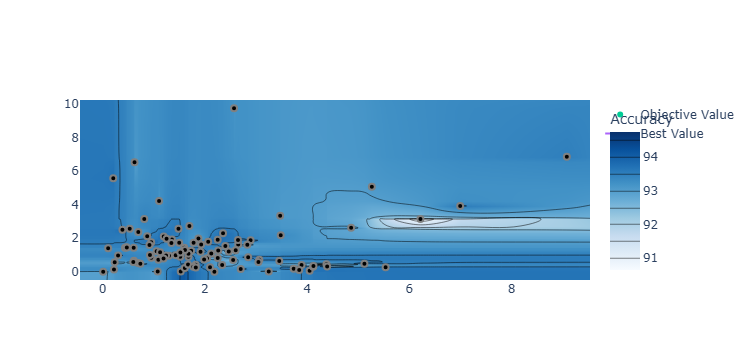

In [44]:
import plotly
import optuna.visualization as ov
import plotly.graph_objs as go
import plotly.io as pio
plotly.offline.init_notebook_mode(connected=True)
# 绘制等高线图
fig_contour = ov.plot_contour(study, params=["$\sigma_1$", "$\sigma_2$"])
fig_contour.update_layout(title='', xaxis_title='$\sigma_1$', yaxis_title='$\sigma_2$')
fig_contour['data'][0]['colorbar']['title']['text'] = 'Accuracy'

# 保存等高线图为 HTML 文件
# 绘制学习曲线
fig_history = ov.plot_optimization_history(study)
fig_history.update_layout(title='Optimization History', xaxis_title='Trial', yaxis_title='Objective Value')

# 将等高线图和学习曲线组合在一起显示
fig_combined = go.Figure()
fig_combined.add_traces(fig_contour.data + fig_history.data)
fig_combined.update_layout(fig_contour.layout)

# 在 Jupyter Notebook 中显示图形
fig_combined.show()

In [45]:
print("\033[92mIf you've read this far, you've probably discovered that after peeling yams, you should never touch your face with your hands—it's very, very itchy.\033[0m")

# If you've read this far, you've probably discovered that after peeling yams, you should never touch your face with your hands—it's very, very itchy.

If you've read this far, you've probably discovered that after peeling yams, you should never touch your face with your hands—it's very, very itchy.


In [47]:
class SiLUB(nn.Module): #带参数的gelu激活函数
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'sigma_{seqFlag}',0,10) #可学习参数 sigma
#在这个字符串格式中，f-string 中的 {} 用于引用变量或表达式的值。在你提供的代码中，
#f'$\sigma_{seqFlag}$' 中的 {} 用于将 seqFlag 的值插入到字符串中，形成一个带有动态值的字符串
    def forward(self, input):
        x =  input * torch.sigmoid(input / self.sigma)
        return x
    
##########################################
class MLPSiLUB(nn.Module):
    def __init__(self, trial):
        super(MLPSiLUB, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.silub1 = SiLUB(1,trial)  # $\sigma_{seqFlag}$
        self.silub2 = SiLUB(2,trial)
    
    def forward(self,X):
        X = self.silub1(self.linear1(X))
        X = self.silub2(self.linear2(X))
        X = self.linear3(X)
        return X

def objective(trial):
    # 定义模型
    mlpsilub = MLPSiLUB(trial)  # 在这里传递 trial 对象给 GEU 类以动态设置参数
    #注意下面很多需要改mlpgeub模型名字，如果你换一个model
    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(mlpsilub.parameters())
    error = nn.CrossEntropyLoss()
    
    EPOCHS = 20
    
    for epoch in range(EPOCHS):
        correct = 0
        ave_correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = mlpsilub(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == var_y_batch).sum()

        ave_correct = float(correct) / len(train_loader.dataset) * 100


    # 打印最后一个 epoch 的准确率
    print('Epoch : {} \tAccuracy:{:.3f}%'.format(EPOCHS, ave_correct))

        # 在该模型上进行测试集评估
    correct_test = 0
    total_samples = len(test)
    mlpsilub.eval()
    with torch.no_grad():
        for test_imgs, test_labels in test:
            test_imgs = test_imgs.float()  # 将输入数据类型转换为 Float
            output = mlpsilub(test_imgs.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            correct_test += (predicted == test_labels).item()
    accuracy = correct_test / total_samples * 100
    # 返回目标值
    return accuracy

# 创建一个 Optuna study 对象
study = optuna.create_study(direction='maximize')

# 运行优化过程
study.optimize(objective, n_trials=100)

# 打印最佳参数和目标值
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-03-22 15:01:07,510] A new study created in memory with name: no-name-e1e36978-50a7-485c-8848-fd67eb409546


Epoch : 20 	Accuracy:94.121%


[I 2024-03-22 15:01:30,388] Trial 0 finished with value: 92.53333333333333 and parameters: {'sigma_1': 7.0762487204285405, 'sigma_2': 6.3195401125935895}. Best is trial 0 with value: 92.53333333333333.


Epoch : 20 	Accuracy:95.806%


[I 2024-03-22 15:01:53,581] Trial 1 finished with value: 93.25833333333333 and parameters: {'sigma_1': 4.69867799817686, 'sigma_2': 4.729876758001418}. Best is trial 1 with value: 93.25833333333333.


Epoch : 20 	Accuracy:94.360%


[I 2024-03-22 15:02:16,665] Trial 2 finished with value: 93.15 and parameters: {'sigma_1': 9.757998478405435, 'sigma_2': 0.5080016241009766}. Best is trial 1 with value: 93.25833333333333.


Epoch : 20 	Accuracy:96.337%


[I 2024-03-22 15:02:41,314] Trial 3 finished with value: 93.63333333333334 and parameters: {'sigma_1': 1.2493341228479216, 'sigma_2': 1.7239581861528153}. Best is trial 3 with value: 93.63333333333334.


Epoch : 20 	Accuracy:95.600%


[I 2024-03-22 15:03:03,753] Trial 4 finished with value: 93.25833333333333 and parameters: {'sigma_1': 8.548729569154853, 'sigma_2': 2.870780158786382}. Best is trial 3 with value: 93.63333333333334.


Epoch : 20 	Accuracy:92.156%


[I 2024-03-22 15:03:28,557] Trial 5 finished with value: 90.93333333333334 and parameters: {'sigma_1': 1.3518344176485675, 'sigma_2': 6.124070377816847}. Best is trial 3 with value: 93.63333333333334.


Epoch : 20 	Accuracy:95.638%


[I 2024-03-22 15:03:52,094] Trial 6 finished with value: 92.95 and parameters: {'sigma_1': 4.008773624007848, 'sigma_2': 7.0170871540894435}. Best is trial 3 with value: 93.63333333333334.


Epoch : 20 	Accuracy:96.138%


[I 2024-03-22 15:04:16,879] Trial 7 finished with value: 93.77499999999999 and parameters: {'sigma_1': 2.7400928343397677, 'sigma_2': 6.0119603256543}. Best is trial 7 with value: 93.77499999999999.


Epoch : 20 	Accuracy:96.154%


[I 2024-03-22 15:04:38,848] Trial 8 finished with value: 92.68333333333332 and parameters: {'sigma_1': 9.981910154329821, 'sigma_2': 6.547962495539158}. Best is trial 7 with value: 93.77499999999999.


Epoch : 20 	Accuracy:96.250%


[I 2024-03-22 15:05:02,264] Trial 9 finished with value: 93.0 and parameters: {'sigma_1': 7.173103345597656, 'sigma_2': 9.517295987678155}. Best is trial 7 with value: 93.77499999999999.


Epoch : 20 	Accuracy:95.044%


[I 2024-03-22 15:05:26,799] Trial 10 finished with value: 93.49166666666666 and parameters: {'sigma_1': 2.795417230090802, 'sigma_2': 3.795026820751043}. Best is trial 7 with value: 93.77499999999999.


Epoch : 20 	Accuracy:94.100%


[I 2024-03-22 15:05:51,958] Trial 11 finished with value: 93.15 and parameters: {'sigma_1': 0.5735284711039418, 'sigma_2': 1.3438466050721667}. Best is trial 7 with value: 93.77499999999999.


Epoch : 20 	Accuracy:95.910%


[I 2024-03-22 15:06:16,812] Trial 12 finished with value: 93.98333333333333 and parameters: {'sigma_1': 2.115442002041342, 'sigma_2': 1.7980895269744428}. Best is trial 12 with value: 93.98333333333333.


Epoch : 20 	Accuracy:95.325%


[I 2024-03-22 15:06:41,290] Trial 13 finished with value: 93.04166666666667 and parameters: {'sigma_1': 2.7392798629817428, 'sigma_2': 3.4781329330738964}. Best is trial 12 with value: 93.98333333333333.


Epoch : 20 	Accuracy:95.773%


[I 2024-03-22 15:07:06,587] Trial 14 finished with value: 94.19999999999999 and parameters: {'sigma_1': 2.8593723816645635, 'sigma_2': 0.20139996925724857}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:96.273%


[I 2024-03-22 15:07:31,726] Trial 15 finished with value: 94.13333333333334 and parameters: {'sigma_1': 0.2322596210183896, 'sigma_2': 0.13936057066147023}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:95.306%


[I 2024-03-22 15:07:57,204] Trial 16 finished with value: 93.48333333333333 and parameters: {'sigma_1': 0.2481980004431712, 'sigma_2': 0.007796092305838914}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:96.965%


[I 2024-03-22 15:08:22,276] Trial 17 finished with value: 93.77499999999999 and parameters: {'sigma_1': 0.5613241314791209, 'sigma_2': 0.4776860509600839}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:94.748%


[I 2024-03-22 15:08:48,686] Trial 18 finished with value: 92.9 and parameters: {'sigma_1': 1.7865420634881601, 'sigma_2': 0.013173698173401582}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:92.263%


[I 2024-03-22 15:09:12,785] Trial 19 finished with value: 91.01666666666667 and parameters: {'sigma_1': 3.6895005956698737, 'sigma_2': 2.6813344885157675}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:93.825%


[I 2024-03-22 15:09:37,825] Trial 20 finished with value: 92.26666666666667 and parameters: {'sigma_1': 0.15741330636569595, 'sigma_2': 1.2860516766010155}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:95.073%


[I 2024-03-22 15:10:02,799] Trial 21 finished with value: 92.96666666666667 and parameters: {'sigma_1': 1.9554803184052383, 'sigma_2': 1.501077015180247}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:95.458%


[I 2024-03-22 15:10:27,763] Trial 22 finished with value: 93.35 and parameters: {'sigma_1': 2.106438754228969, 'sigma_2': 1.838830750625843}. Best is trial 14 with value: 94.19999999999999.


Epoch : 20 	Accuracy:96.794%


[I 2024-03-22 15:10:52,942] Trial 23 finished with value: 94.46666666666667 and parameters: {'sigma_1': 1.1839250357760265, 'sigma_2': 0.778241731213646}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.269%


[I 2024-03-22 15:11:18,908] Trial 24 finished with value: 93.25833333333333 and parameters: {'sigma_1': 0.9431240621242205, 'sigma_2': 0.1507043989328678}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.590%


[I 2024-03-22 15:11:44,317] Trial 25 finished with value: 93.79166666666666 and parameters: {'sigma_1': 1.0765219591740705, 'sigma_2': 0.7286680061887327}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.448%


[I 2024-03-22 15:12:08,489] Trial 26 finished with value: 93.72500000000001 and parameters: {'sigma_1': 0.3711769520225565, 'sigma_2': 0.9945149237797377}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.056%


[I 2024-03-22 15:12:33,421] Trial 27 finished with value: 92.65 and parameters: {'sigma_1': 1.577090044775671, 'sigma_2': 0.8856571637640047}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.348%


[I 2024-03-22 15:12:57,270] Trial 28 finished with value: 93.99166666666666 and parameters: {'sigma_1': 0.1413352925223128, 'sigma_2': 2.4335007985618073}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.523%


[I 2024-03-22 15:13:19,942] Trial 29 finished with value: 93.25833333333333 and parameters: {'sigma_1': 5.926574439116921, 'sigma_2': 2.107632030670844}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.588%


[I 2024-03-22 15:13:44,042] Trial 30 finished with value: 93.35833333333333 and parameters: {'sigma_1': 3.3847551534478764, 'sigma_2': 0.8976680114185496}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.371%


[I 2024-03-22 15:14:08,038] Trial 31 finished with value: 93.05833333333334 and parameters: {'sigma_1': 0.1914009255461463, 'sigma_2': 2.228842067911617}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.060%


[I 2024-03-22 15:14:33,425] Trial 32 finished with value: 92.56666666666666 and parameters: {'sigma_1': 0.9708293693665991, 'sigma_2': 0.6652076894458364}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.719%


[I 2024-03-22 15:14:57,344] Trial 33 finished with value: 93.50833333333334 and parameters: {'sigma_1': 0.0334350638654648, 'sigma_2': 1.0961120146213723}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.962%


[I 2024-03-22 15:15:22,808] Trial 34 finished with value: 93.44166666666666 and parameters: {'sigma_1': 0.8667974264162152, 'sigma_2': 0.11182344803370582}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.481%


[I 2024-03-22 15:15:47,487] Trial 35 finished with value: 93.01666666666667 and parameters: {'sigma_1': 1.4381026853962573, 'sigma_2': 2.5333166725465497}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.412%


[I 2024-03-22 15:16:11,978] Trial 36 finished with value: 93.55 and parameters: {'sigma_1': 1.268738619809588, 'sigma_2': 1.5900488471122831}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.208%


[I 2024-03-22 15:16:37,208] Trial 37 finished with value: 93.60000000000001 and parameters: {'sigma_1': 2.308239990478315, 'sigma_2': 0.5615996017361872}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.315%


[I 2024-03-22 15:17:01,647] Trial 38 finished with value: 92.86666666666666 and parameters: {'sigma_1': 0.6937077635001923, 'sigma_2': 2.116527570726937}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:93.263%


[I 2024-03-22 15:17:26,600] Trial 39 finished with value: 91.875 and parameters: {'sigma_1': 1.5400003665552557, 'sigma_2': 1.279864831136716}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.794%


[I 2024-03-22 15:17:51,462] Trial 40 finished with value: 92.30000000000001 and parameters: {'sigma_1': 1.1544353921722181, 'sigma_2': 2.947258994236523}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.363%


[I 2024-03-22 15:18:16,417] Trial 41 finished with value: 92.95 and parameters: {'sigma_1': 2.2693993985893814, 'sigma_2': 1.8183788366132494}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.473%


[I 2024-03-22 15:18:41,529] Trial 42 finished with value: 94.22500000000001 and parameters: {'sigma_1': 1.846347564212434, 'sigma_2': 0.5481670305084241}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.079%


[I 2024-03-22 15:19:06,362] Trial 43 finished with value: 93.84166666666667 and parameters: {'sigma_1': 0.034502921260546326, 'sigma_2': 0.7059577599095714}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.213%


[I 2024-03-22 15:19:31,730] Trial 44 finished with value: 94.19166666666666 and parameters: {'sigma_1': 0.635722507656177, 'sigma_2': 0.3492988757277812}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.865%


[I 2024-03-22 15:19:57,382] Trial 45 finished with value: 93.99166666666666 and parameters: {'sigma_1': 1.7112448125032185, 'sigma_2': 0.29744965679283913}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:93.904%


[I 2024-03-22 15:20:23,102] Trial 46 finished with value: 92.05833333333334 and parameters: {'sigma_1': 2.7401478758475992, 'sigma_2': 0.3682957994102882}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.475%


[I 2024-03-22 15:20:48,243] Trial 47 finished with value: 92.60000000000001 and parameters: {'sigma_1': 0.6746672648744456, 'sigma_2': 1.1528124932018728}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.944%


[I 2024-03-22 15:21:12,643] Trial 48 finished with value: 93.60000000000001 and parameters: {'sigma_1': 4.371922659226977, 'sigma_2': 0.4927484920696876}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.667%


[I 2024-03-22 15:21:37,145] Trial 49 finished with value: 93.28333333333333 and parameters: {'sigma_1': 1.3472435592311487, 'sigma_2': 1.401561089072861}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:90.081%


[I 2024-03-22 15:22:03,252] Trial 50 finished with value: 88.96666666666667 and parameters: {'sigma_1': 2.406742340521056, 'sigma_2': 0.028603143161057887}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.444%


[I 2024-03-22 15:22:27,616] Trial 51 finished with value: 93.25 and parameters: {'sigma_1': 0.6856338869811491, 'sigma_2': 0.8590145039990398}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.108%


[I 2024-03-22 15:22:52,645] Trial 52 finished with value: 94.09166666666667 and parameters: {'sigma_1': 0.5329994061464722, 'sigma_2': 0.39108414014047765}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.398%


[I 2024-03-22 15:23:17,298] Trial 53 finished with value: 94.125 and parameters: {'sigma_1': 1.8319948868860532, 'sigma_2': 0.42456887091957907}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:90.385%


[I 2024-03-22 15:23:42,140] Trial 54 finished with value: 89.10833333333333 and parameters: {'sigma_1': 1.8169708999951566, 'sigma_2': 1.5927709214727215}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.502%


[I 2024-03-22 15:24:07,566] Trial 55 finished with value: 93.01666666666667 and parameters: {'sigma_1': 3.153833912538351, 'sigma_2': 0.022020151504238528}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.713%


[I 2024-03-22 15:24:32,740] Trial 56 finished with value: 93.15833333333333 and parameters: {'sigma_1': 1.9286660720098734, 'sigma_2': 1.14347944908901}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.129%


[I 2024-03-22 15:24:59,034] Trial 57 finished with value: 94.25833333333333 and parameters: {'sigma_1': 2.4378521419454087, 'sigma_2': 0.49830589755293386}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.200%


[I 2024-03-22 15:25:24,499] Trial 58 finished with value: 92.875 and parameters: {'sigma_1': 3.0008779701066945, 'sigma_2': 0.8282018339060339}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.879%


[I 2024-03-22 15:25:51,693] Trial 59 finished with value: 93.20833333333334 and parameters: {'sigma_1': 2.5214868321432533, 'sigma_2': 1.7189764836751231}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.667%


[I 2024-03-22 15:26:17,308] Trial 60 finished with value: 93.18333333333332 and parameters: {'sigma_1': 3.5322281645902187, 'sigma_2': 0.5422004819090229}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.840%


[I 2024-03-22 15:26:43,478] Trial 61 finished with value: 93.10000000000001 and parameters: {'sigma_1': 1.1363850122975414, 'sigma_2': 0.3684127364023653}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:93.504%


[I 2024-03-22 15:27:09,197] Trial 62 finished with value: 91.44166666666666 and parameters: {'sigma_1': 2.003328519655058, 'sigma_2': 1.082461904215517}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.365%


[I 2024-03-22 15:27:35,100] Trial 63 finished with value: 94.3 and parameters: {'sigma_1': 1.6417912558250605, 'sigma_2': 0.329093958726114}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.788%


[I 2024-03-22 15:28:00,547] Trial 64 finished with value: 93.63333333333334 and parameters: {'sigma_1': 2.5269193424309937, 'sigma_2': 0.8398500143110681}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.492%


[I 2024-03-22 15:28:26,389] Trial 65 finished with value: 92.76666666666667 and parameters: {'sigma_1': 1.4412490903952713, 'sigma_2': 1.3532519724959924}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.344%


[I 2024-03-22 15:28:52,877] Trial 66 finished with value: 93.06666666666666 and parameters: {'sigma_1': 0.8448597795019087, 'sigma_2': 0.2670842992596112}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.552%


[I 2024-03-22 15:29:19,005] Trial 67 finished with value: 93.27499999999999 and parameters: {'sigma_1': 0.3961001392182446, 'sigma_2': 0.05832713100226422}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.856%


[I 2024-03-22 15:29:44,746] Trial 68 finished with value: 94.08333333333333 and parameters: {'sigma_1': 1.5742551632891926, 'sigma_2': 0.6709729281651784}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.035%


[I 2024-03-22 15:30:09,635] Trial 69 finished with value: 93.825 and parameters: {'sigma_1': 2.181963077395702, 'sigma_2': 1.0597747229668024}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:91.612%


[I 2024-03-22 15:30:34,913] Trial 70 finished with value: 89.58333333333334 and parameters: {'sigma_1': 1.0947039554707705, 'sigma_2': 1.425536864448162}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.106%


[I 2024-03-22 15:31:00,476] Trial 71 finished with value: 93.89166666666667 and parameters: {'sigma_1': 1.8474364152432095, 'sigma_2': 0.33681574825551974}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.188%


[I 2024-03-22 15:31:25,658] Trial 72 finished with value: 93.39166666666667 and parameters: {'sigma_1': 0.44215067405766456, 'sigma_2': 0.6855262035950058}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:93.925%


[I 2024-03-22 15:31:52,831] Trial 73 finished with value: 92.35833333333333 and parameters: {'sigma_1': 1.6545958748482872, 'sigma_2': 0.43371436537889324}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.506%


[I 2024-03-22 15:32:19,798] Trial 74 finished with value: 93.75833333333333 and parameters: {'sigma_1': 1.3302601799571487, 'sigma_2': 0.9267533238386685}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.727%


[I 2024-03-22 15:32:46,495] Trial 75 finished with value: 92.75833333333333 and parameters: {'sigma_1': 0.9299843283578945, 'sigma_2': 0.22852542971994066}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.069%


[I 2024-03-22 15:33:13,395] Trial 76 finished with value: 93.35833333333333 and parameters: {'sigma_1': 2.195546962402795, 'sigma_2': 0.018684317057699795}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.698%


[I 2024-03-22 15:33:39,009] Trial 77 finished with value: 92.59166666666667 and parameters: {'sigma_1': 2.993223481338198, 'sigma_2': 1.9856763922044038}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.660%


[I 2024-03-22 15:34:05,841] Trial 78 finished with value: 93.84166666666667 and parameters: {'sigma_1': 2.654103065570112, 'sigma_2': 0.5956761026585642}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.585%


[I 2024-03-22 15:34:31,437] Trial 79 finished with value: 93.31666666666666 and parameters: {'sigma_1': 2.051298039408858, 'sigma_2': 1.557245837565857}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.796%


[I 2024-03-22 15:34:56,173] Trial 80 finished with value: 93.51666666666667 and parameters: {'sigma_1': 0.2770976254239097, 'sigma_2': 1.1453621875501805}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.442%


[I 2024-03-22 15:35:22,669] Trial 81 finished with value: 93.18333333333332 and parameters: {'sigma_1': 0.7547037371814515, 'sigma_2': 0.41542716193801116}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.831%


[I 2024-03-22 15:35:48,313] Trial 82 finished with value: 93.18333333333332 and parameters: {'sigma_1': 0.5427998280437998, 'sigma_2': 0.6666537013651499}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.621%


[I 2024-03-22 15:36:15,535] Trial 83 finished with value: 92.93333333333334 and parameters: {'sigma_1': 1.2397098518583376, 'sigma_2': 0.2973183550434591}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.015%


[I 2024-03-22 15:36:40,622] Trial 84 finished with value: 92.975 and parameters: {'sigma_1': 0.0029689233967792328, 'sigma_2': 1.0015512464930643}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.198%


[I 2024-03-22 15:37:07,462] Trial 85 finished with value: 92.18333333333332 and parameters: {'sigma_1': 0.9589529346991664, 'sigma_2': 0.21329389019084433}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.727%


[I 2024-03-22 15:37:34,523] Trial 86 finished with value: 93.925 and parameters: {'sigma_1': 1.6210339323429612, 'sigma_2': 0.5343407989900751}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.646%


[I 2024-03-22 15:37:59,657] Trial 87 finished with value: 92.48333333333333 and parameters: {'sigma_1': 0.341877911755319, 'sigma_2': 0.825428520141305}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.756%


[I 2024-03-22 15:38:24,306] Trial 88 finished with value: 93.375 and parameters: {'sigma_1': 0.5388904440843034, 'sigma_2': 1.3315450872924623}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.981%


[I 2024-03-22 15:38:50,910] Trial 89 finished with value: 94.20833333333334 and parameters: {'sigma_1': 1.3718868103513788, 'sigma_2': 0.24142719594938175}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.690%


[I 2024-03-22 15:39:16,944] Trial 90 finished with value: 93.68333333333332 and parameters: {'sigma_1': 1.801249516851087, 'sigma_2': 0.18121526837053087}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:94.719%


[I 2024-03-22 15:39:43,347] Trial 91 finished with value: 92.46666666666667 and parameters: {'sigma_1': 2.357800639545892, 'sigma_2': 0.5566092113046482}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.202%


[I 2024-03-22 15:40:08,898] Trial 92 finished with value: 93.91666666666667 and parameters: {'sigma_1': 1.329967279075566, 'sigma_2': 0.8124387596312324}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.296%


[I 2024-03-22 15:40:34,465] Trial 93 finished with value: 94.0 and parameters: {'sigma_1': 0.7430989767154931, 'sigma_2': 0.39898410936980133}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.577%


[I 2024-03-22 15:41:00,907] Trial 94 finished with value: 93.18333333333332 and parameters: {'sigma_1': 1.0954532108891453, 'sigma_2': 0.004272156615595379}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.067%


[I 2024-03-22 15:41:27,326] Trial 95 finished with value: 93.975 and parameters: {'sigma_1': 1.4184970430720205, 'sigma_2': 1.1742541081039488}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.752%


[I 2024-03-22 15:41:53,096] Trial 96 finished with value: 93.70833333333334 and parameters: {'sigma_1': 1.9995132061380292, 'sigma_2': 0.9698611197906466}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.250%


[I 2024-03-22 15:42:19,457] Trial 97 finished with value: 94.05833333333334 and parameters: {'sigma_1': 1.7705075837869941, 'sigma_2': 0.24244852675876588}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:95.648%


[I 2024-03-22 15:42:44,800] Trial 98 finished with value: 93.49166666666666 and parameters: {'sigma_1': 0.9622529597926728, 'sigma_2': 0.6723906128439862}. Best is trial 23 with value: 94.46666666666667.


Epoch : 20 	Accuracy:96.302%


[I 2024-03-22 15:43:11,195] Trial 99 finished with value: 93.53333333333333 and parameters: {'sigma_1': 1.4953499137435684, 'sigma_2': 0.4735570185778812}. Best is trial 23 with value: 94.46666666666667.


Best trial:
  Value:  94.46666666666667
  Params: 
    sigma_1: 1.1839250357760265
    sigma_2: 0.778241731213646


In [48]:
class RayLUB(nn.Module): #带参数的Raylu激活函数
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'sigma_{seqFlag}',0,10) #可学习参数 sigma
#在这个字符串格式中，f-string 中的 {} 用于引用变量或表达式的值。在你提供的代码中，
#f'$\sigma_{seqFlag}$' 中的 {} 用于将 seqFlag 的值插入到字符串中，形成一个带有动态值的字符串
    def forward(self, input):
        x = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2))
        return x
    
##########################################
class MLPRayLUB(nn.Module):
    def __init__(self, trial):
        super(MLPRayLUB, self).__init__()
        self.linear1 = nn.Linear(784,20)
        self.linear2 = nn.Linear(20,20)
        self.linear3 = nn.Linear(20,10)
        self.raylub1 = RayLUB(1,trial)  # $\sigma_{seqFlag}$
        self.raylub2 = RayLUB(2,trial)
    
    def forward(self,X):
        X = self.raylub1(self.linear1(X))
        X = self.raylub2(self.linear2(X))
        X = self.linear3(X)
        return X

def objective(trial):
    # 定义模型
    mlpraylub = MLPRayLUB(trial)  # 在这里传递 trial 对象给 GEU 类以动态设置参数
    #注意下面很多需要改mlpgeub模型名字，如果你换一个model
    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(mlpraylub.parameters())
    error = nn.CrossEntropyLoss()
    
    EPOCHS = 20
    
    for epoch in range(EPOCHS):
        correct = 0
        ave_correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = mlpraylub(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == var_y_batch).sum()

        ave_correct = float(correct) / len(train_loader.dataset) * 100


    # 打印最后一个 epoch 的准确率
    print('Epoch : {} \tAccuracy:{:.3f}%'.format(EPOCHS, ave_correct))

        # 在该模型上进行测试集评估
    correct_test = 0
    total_samples = len(test)
    mlpraylub.eval()
    with torch.no_grad():
        for test_imgs, test_labels in test:
            test_imgs = test_imgs.float()  # 将输入数据类型转换为 Float
            output = mlpraylub(test_imgs.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            correct_test += (predicted == test_labels).item()
    accuracy = correct_test / total_samples * 100
    # 返回目标值
    return accuracy

# 创建一个 Optuna study 对象
study = optuna.create_study(direction='maximize')

# 运行优化过程
study.optimize(objective, n_trials=100)

# 打印最佳参数和目标值
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-03-22 15:43:11,254] A new study created in memory with name: no-name-4b8b9897-4da8-4f00-baff-c185575902bd


Epoch : 20 	Accuracy:95.590%


[I 2024-03-22 15:43:39,278] Trial 0 finished with value: 93.22500000000001 and parameters: {'sigma_1': 5.032069762457788, 'sigma_2': 5.183074168530208}. Best is trial 0 with value: 93.22500000000001.


Epoch : 20 	Accuracy:96.519%


[I 2024-03-22 15:44:05,924] Trial 1 finished with value: 93.95833333333333 and parameters: {'sigma_1': 2.3351932360485375, 'sigma_2': 9.695074466297944}. Best is trial 1 with value: 93.95833333333333.


Epoch : 20 	Accuracy:95.662%


[I 2024-03-22 15:44:33,626] Trial 2 finished with value: 93.49166666666666 and parameters: {'sigma_1': 1.8118255752860601, 'sigma_2': 4.298871617273741}. Best is trial 1 with value: 93.95833333333333.


Epoch : 20 	Accuracy:95.817%


[I 2024-03-22 15:45:01,476] Trial 3 finished with value: 93.4 and parameters: {'sigma_1': 9.270227959205016, 'sigma_2': 7.037032528761275}. Best is trial 1 with value: 93.95833333333333.


Epoch : 20 	Accuracy:94.971%


[I 2024-03-22 15:45:28,206] Trial 4 finished with value: 92.55833333333334 and parameters: {'sigma_1': 4.2168105100834286, 'sigma_2': 3.702205673375083}. Best is trial 1 with value: 93.95833333333333.


Epoch : 20 	Accuracy:96.631%


[I 2024-03-22 15:45:55,842] Trial 5 finished with value: 94.61666666666667 and parameters: {'sigma_1': 9.180485665901278, 'sigma_2': 8.213898757289039}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.027%


[I 2024-03-22 15:46:23,415] Trial 6 finished with value: 93.025 and parameters: {'sigma_1': 5.6307410474397965, 'sigma_2': 0.9866873986383129}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.950%


[I 2024-03-22 15:46:50,974] Trial 7 finished with value: 91.85 and parameters: {'sigma_1': 8.384529609160131, 'sigma_2': 4.014357172262807}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.679%


[I 2024-03-22 15:47:17,637] Trial 8 finished with value: 92.05 and parameters: {'sigma_1': 4.869266458812424, 'sigma_2': 5.037174935209835}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.748%


[I 2024-03-22 15:47:44,796] Trial 9 finished with value: 93.475 and parameters: {'sigma_1': 5.8152629229843456, 'sigma_2': 6.2038792906473175}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.290%


[I 2024-03-22 15:48:12,421] Trial 10 finished with value: 93.625 and parameters: {'sigma_1': 9.963946258685999, 'sigma_2': 9.55040979656457}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.525%


[I 2024-03-22 15:48:39,263] Trial 11 finished with value: 92.68333333333332 and parameters: {'sigma_1': 0.39269154646132165, 'sigma_2': 9.82761578036662}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.621%


[I 2024-03-22 15:49:06,074] Trial 12 finished with value: 93.575 and parameters: {'sigma_1': 7.643987561251995, 'sigma_2': 8.564486555785333}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.710%


[I 2024-03-22 15:49:33,652] Trial 13 finished with value: 92.65833333333333 and parameters: {'sigma_1': 3.0214398110194196, 'sigma_2': 8.200072508268827}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.821%


[I 2024-03-22 15:50:01,558] Trial 14 finished with value: 93.21666666666667 and parameters: {'sigma_1': 6.847339584342373, 'sigma_2': 8.302045591064555}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.331%


[I 2024-03-22 15:50:28,868] Trial 15 finished with value: 92.225 and parameters: {'sigma_1': 3.0048770246633816, 'sigma_2': 9.780949082415242}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.542%


[I 2024-03-22 15:50:56,406] Trial 16 finished with value: 92.675 and parameters: {'sigma_1': 6.752165922203291, 'sigma_2': 7.134655569117961}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.898%


[I 2024-03-22 15:51:24,553] Trial 17 finished with value: 93.60833333333333 and parameters: {'sigma_1': 8.546762968712175, 'sigma_2': 8.72534686644512}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.023%


[I 2024-03-22 15:51:51,512] Trial 18 finished with value: 92.16666666666666 and parameters: {'sigma_1': 0.21227585812618122, 'sigma_2': 9.968663379449543}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.156%


[I 2024-03-22 15:52:18,723] Trial 19 finished with value: 92.08333333333333 and parameters: {'sigma_1': 9.870367433415257, 'sigma_2': 7.431453239258881}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.194%


[I 2024-03-22 15:52:45,092] Trial 20 finished with value: 92.53333333333333 and parameters: {'sigma_1': 3.4901239090510683, 'sigma_2': 8.97406102586458}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.460%


[I 2024-03-22 15:53:11,549] Trial 21 finished with value: 93.075 and parameters: {'sigma_1': 9.966524381995361, 'sigma_2': 9.596357932077918}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.823%


[I 2024-03-22 15:53:38,538] Trial 22 finished with value: 93.80833333333334 and parameters: {'sigma_1': 8.93977399222904, 'sigma_2': 8.792820089272448}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:92.242%


[I 2024-03-22 15:54:05,900] Trial 23 finished with value: 90.2 and parameters: {'sigma_1': 8.504438112739646, 'sigma_2': 7.632450781506024}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.327%


[I 2024-03-22 15:54:32,327] Trial 24 finished with value: 94.19999999999999 and parameters: {'sigma_1': 7.548806803803197, 'sigma_2': 8.867575984579029}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.740%


[I 2024-03-22 15:54:59,609] Trial 25 finished with value: 92.525 and parameters: {'sigma_1': 7.63742871203323, 'sigma_2': 6.355378094311567}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.242%


[I 2024-03-22 15:55:26,017] Trial 26 finished with value: 93.39166666666667 and parameters: {'sigma_1': 7.50267855880465, 'sigma_2': 8.912071780475777}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.688%


[I 2024-03-22 15:55:52,660] Trial 27 finished with value: 92.25833333333333 and parameters: {'sigma_1': 6.449873023951031, 'sigma_2': 8.050978487461624}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.125%


[I 2024-03-22 15:56:19,160] Trial 28 finished with value: 93.61666666666667 and parameters: {'sigma_1': 2.0067212242488197, 'sigma_2': 9.151956819811144}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.510%


[I 2024-03-22 15:56:46,069] Trial 29 finished with value: 94.375 and parameters: {'sigma_1': 4.510938192314573, 'sigma_2': 7.875056557596686}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.604%


[I 2024-03-22 15:57:13,994] Trial 30 finished with value: 93.51666666666667 and parameters: {'sigma_1': 5.090829841501876, 'sigma_2': 7.983663685064394}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.446%


[I 2024-03-22 15:57:40,362] Trial 31 finished with value: 94.00833333333334 and parameters: {'sigma_1': 4.236382950099581, 'sigma_2': 9.19893816456783}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.385%


[I 2024-03-22 15:58:07,060] Trial 32 finished with value: 90.975 and parameters: {'sigma_1': 3.9316936309280517, 'sigma_2': 7.75762796835091}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.240%


[I 2024-03-22 15:58:33,410] Trial 33 finished with value: 93.86666666666666 and parameters: {'sigma_1': 4.751763719171226, 'sigma_2': 9.207070996272892}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.694%


[I 2024-03-22 15:58:59,984] Trial 34 finished with value: 93.27499999999999 and parameters: {'sigma_1': 5.727020641420699, 'sigma_2': 8.519016836595592}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.346%


[I 2024-03-22 15:59:26,639] Trial 35 finished with value: 94.51666666666667 and parameters: {'sigma_1': 4.400549106918294, 'sigma_2': 6.943884809924624}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.260%


[I 2024-03-22 15:59:53,089] Trial 36 finished with value: 93.83333333333333 and parameters: {'sigma_1': 8.99224865548441, 'sigma_2': 6.788446151482534}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.381%


[I 2024-03-22 16:00:19,682] Trial 37 finished with value: 91.98333333333333 and parameters: {'sigma_1': 5.250782236252915, 'sigma_2': 5.962158121544891}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.008%


[I 2024-03-22 16:00:46,473] Trial 38 finished with value: 90.95 and parameters: {'sigma_1': 6.1773780488571886, 'sigma_2': 7.252432449594415}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.344%


[I 2024-03-22 16:01:13,800] Trial 39 finished with value: 94.09166666666667 and parameters: {'sigma_1': 4.767180430987926, 'sigma_2': 6.73656984332086}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.240%


[I 2024-03-22 16:01:41,453] Trial 40 finished with value: 93.94166666666666 and parameters: {'sigma_1': 7.138216440937942, 'sigma_2': 5.7916140733296695}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.054%


[I 2024-03-22 16:02:08,045] Trial 41 finished with value: 92.25833333333333 and parameters: {'sigma_1': 4.6046313167600506, 'sigma_2': 6.828819857726631}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.748%


[I 2024-03-22 16:02:34,593] Trial 42 finished with value: 94.56666666666666 and parameters: {'sigma_1': 4.4906192658985224, 'sigma_2': 7.348379528188386}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.602%


[I 2024-03-22 16:03:00,892] Trial 43 finished with value: 92.88333333333333 and parameters: {'sigma_1': 4.141311660023847, 'sigma_2': 7.587710594692549}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.719%


[I 2024-03-22 16:03:27,783] Trial 44 finished with value: 93.575 and parameters: {'sigma_1': 5.350514364946412, 'sigma_2': 7.9181666873231045}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.010%


[I 2024-03-22 16:03:54,421] Trial 45 finished with value: 92.65833333333333 and parameters: {'sigma_1': 6.046815343775821, 'sigma_2': 8.258924071846344}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.869%


[I 2024-03-22 16:04:21,179] Trial 46 finished with value: 93.16666666666666 and parameters: {'sigma_1': 5.699253641753506, 'sigma_2': 7.296483116148536}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.979%


[I 2024-03-22 16:04:48,319] Trial 47 finished with value: 92.01666666666667 and parameters: {'sigma_1': 7.996497137521555, 'sigma_2': 5.458976179477762}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.898%


[I 2024-03-22 16:05:14,780] Trial 48 finished with value: 94.14166666666667 and parameters: {'sigma_1': 3.651580773053614, 'sigma_2': 6.416076726373184}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.710%


[I 2024-03-22 16:05:41,255] Trial 49 finished with value: 93.11666666666667 and parameters: {'sigma_1': 4.471636472034504, 'sigma_2': 8.484406163014345}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.494%


[I 2024-03-22 16:06:08,119] Trial 50 finished with value: 93.68333333333332 and parameters: {'sigma_1': 5.438680609488445, 'sigma_2': 7.7059998735920665}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.681%


[I 2024-03-22 16:06:34,754] Trial 51 finished with value: 94.36666666666666 and parameters: {'sigma_1': 3.9200638545825606, 'sigma_2': 6.388921632208099}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.167%


[I 2024-03-22 16:07:01,487] Trial 52 finished with value: 93.0 and parameters: {'sigma_1': 4.950055926032169, 'sigma_2': 7.053725073224067}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.671%


[I 2024-03-22 16:07:28,016] Trial 53 finished with value: 92.39166666666667 and parameters: {'sigma_1': 3.2063186097644314, 'sigma_2': 6.577258420936914}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.750%


[I 2024-03-22 16:07:54,514] Trial 54 finished with value: 93.75 and parameters: {'sigma_1': 3.8684978538650845, 'sigma_2': 7.193624315634164}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.027%


[I 2024-03-22 16:08:20,849] Trial 55 finished with value: 92.68333333333332 and parameters: {'sigma_1': 2.6477990004806706, 'sigma_2': 8.21015458141315}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.650%


[I 2024-03-22 16:08:47,784] Trial 56 finished with value: 93.25833333333333 and parameters: {'sigma_1': 4.39708464988284, 'sigma_2': 7.450116780042208}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.192%


[I 2024-03-22 16:09:14,799] Trial 57 finished with value: 94.19166666666666 and parameters: {'sigma_1': 9.53703976027613, 'sigma_2': 6.264631412711487}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.908%


[I 2024-03-22 16:09:41,362] Trial 58 finished with value: 93.56666666666666 and parameters: {'sigma_1': 4.238957666592207, 'sigma_2': 4.942636830923197}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.850%


[I 2024-03-22 16:10:07,479] Trial 59 finished with value: 93.36666666666666 and parameters: {'sigma_1': 3.4719003087827316, 'sigma_2': 6.951757788174804}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.444%


[I 2024-03-22 16:10:34,052] Trial 60 finished with value: 94.06666666666666 and parameters: {'sigma_1': 5.002378625791509, 'sigma_2': 8.542270777989398}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.515%


[I 2024-03-22 16:11:00,941] Trial 61 finished with value: 91.68333333333332 and parameters: {'sigma_1': 8.924935558256374, 'sigma_2': 6.071896358729886}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.081%


[I 2024-03-22 16:11:27,807] Trial 62 finished with value: 93.325 and parameters: {'sigma_1': 9.631425416882086, 'sigma_2': 6.338643389914917}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.581%


[I 2024-03-22 16:11:54,777] Trial 63 finished with value: 92.84166666666667 and parameters: {'sigma_1': 9.226787374861525, 'sigma_2': 7.822812407747622}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.304%


[I 2024-03-22 16:12:22,163] Trial 64 finished with value: 92.55 and parameters: {'sigma_1': 9.6498343992824, 'sigma_2': 6.56854599766136}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.844%


[I 2024-03-22 16:12:49,237] Trial 65 finished with value: 92.08333333333333 and parameters: {'sigma_1': 8.093213184311198, 'sigma_2': 7.368967762437096}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.092%


[I 2024-03-22 16:13:15,861] Trial 66 finished with value: 91.99166666666667 and parameters: {'sigma_1': 8.503201295741496, 'sigma_2': 8.046623823631531}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.358%


[I 2024-03-22 16:13:42,919] Trial 67 finished with value: 91.68333333333332 and parameters: {'sigma_1': 9.26569185313912, 'sigma_2': 7.0551549590912135}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:97.102%


[I 2024-03-22 16:14:10,091] Trial 68 finished with value: 94.31666666666668 and parameters: {'sigma_1': 3.9561557812276043, 'sigma_2': 9.43387432291633}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.202%


[I 2024-03-22 16:14:36,675] Trial 69 finished with value: 93.65 and parameters: {'sigma_1': 3.985123029048002, 'sigma_2': 9.463980542239481}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.698%


[I 2024-03-22 16:15:03,515] Trial 70 finished with value: 93.05833333333334 and parameters: {'sigma_1': 4.422976243756953, 'sigma_2': 8.783510703717726}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.771%


[I 2024-03-22 16:15:29,875] Trial 71 finished with value: 93.60000000000001 and parameters: {'sigma_1': 4.75288008991481, 'sigma_2': 9.336423345071365}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.973%


[I 2024-03-22 16:15:56,105] Trial 72 finished with value: 91.80833333333334 and parameters: {'sigma_1': 3.747208917179502, 'sigma_2': 9.887836260651174}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.083%


[I 2024-03-22 16:16:22,574] Trial 73 finished with value: 93.69166666666666 and parameters: {'sigma_1': 4.083236762398239, 'sigma_2': 8.97493463299708}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.237%


[I 2024-03-22 16:16:48,921] Trial 74 finished with value: 92.5 and parameters: {'sigma_1': 3.3389199560309817, 'sigma_2': 8.33479995110048}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.121%


[I 2024-03-22 16:17:15,535] Trial 75 finished with value: 92.27499999999999 and parameters: {'sigma_1': 3.675450533202102, 'sigma_2': 9.572203666426628}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.446%


[I 2024-03-22 16:17:42,175] Trial 76 finished with value: 92.61666666666667 and parameters: {'sigma_1': 4.641720293472204, 'sigma_2': 7.6315621161119465}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.198%


[I 2024-03-22 16:18:09,067] Trial 77 finished with value: 91.84166666666667 and parameters: {'sigma_1': 8.746976002899546, 'sigma_2': 8.610973929017959}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.808%


[I 2024-03-22 16:18:35,596] Trial 78 finished with value: 92.79166666666666 and parameters: {'sigma_1': 5.300061724537588, 'sigma_2': 9.00861010078765}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.252%


[I 2024-03-22 16:19:02,228] Trial 79 finished with value: 94.00833333333334 and parameters: {'sigma_1': 5.10434925011732, 'sigma_2': 8.045522056156512}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.260%


[I 2024-03-22 16:19:29,148] Trial 80 finished with value: 93.25833333333333 and parameters: {'sigma_1': 9.593346186836248, 'sigma_2': 6.737340182069387}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.810%


[I 2024-03-22 16:19:55,646] Trial 81 finished with value: 94.13333333333334 and parameters: {'sigma_1': 3.585948765051342, 'sigma_2': 6.370469393766936}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.379%


[I 2024-03-22 16:20:22,502] Trial 82 finished with value: 91.85 and parameters: {'sigma_1': 3.8524682542125124, 'sigma_2': 5.814021127259678}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.952%


[I 2024-03-22 16:20:49,097] Trial 83 finished with value: 93.91666666666667 and parameters: {'sigma_1': 4.288496062627733, 'sigma_2': 7.47938444138413}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.138%


[I 2024-03-22 16:21:15,772] Trial 84 finished with value: 92.46666666666667 and parameters: {'sigma_1': 4.5480434419220215, 'sigma_2': 6.2121891563631}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.248%


[I 2024-03-22 16:21:42,190] Trial 85 finished with value: 93.49166666666666 and parameters: {'sigma_1': 2.8946654238445477, 'sigma_2': 7.201570322197369}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.508%


[I 2024-03-22 16:22:09,680] Trial 86 finished with value: 92.11666666666667 and parameters: {'sigma_1': 9.995711214369592, 'sigma_2': 6.952765222359596}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.144%


[I 2024-03-22 16:22:36,435] Trial 87 finished with value: 92.59166666666667 and parameters: {'sigma_1': 4.061426467526628, 'sigma_2': 6.6025602344206975}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.390%


[I 2024-03-22 16:23:02,756] Trial 88 finished with value: 92.41666666666667 and parameters: {'sigma_1': 4.836800886535433, 'sigma_2': 7.8373800431863}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:94.344%


[I 2024-03-22 16:23:29,442] Trial 89 finished with value: 92.08333333333333 and parameters: {'sigma_1': 3.587307200106763, 'sigma_2': 8.350418300204485}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.779%


[I 2024-03-22 16:23:55,925] Trial 90 finished with value: 94.04166666666667 and parameters: {'sigma_1': 3.283541017618597, 'sigma_2': 9.740684703478484}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.840%


[I 2024-03-22 16:24:22,496] Trial 91 finished with value: 92.10833333333333 and parameters: {'sigma_1': 3.7559609492233283, 'sigma_2': 6.46838404285465}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.015%


[I 2024-03-22 16:24:48,956] Trial 92 finished with value: 93.675 and parameters: {'sigma_1': 4.297666247450779, 'sigma_2': 6.359106684889574}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.862%


[I 2024-03-22 16:25:15,268] Trial 93 finished with value: 93.2 and parameters: {'sigma_1': 3.601880677033595, 'sigma_2': 6.0497762837503215}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.469%


[I 2024-03-22 16:25:41,714] Trial 94 finished with value: 93.44166666666666 and parameters: {'sigma_1': 4.006628401229902, 'sigma_2': 6.903267264064404}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.433%


[I 2024-03-22 16:26:08,669] Trial 95 finished with value: 91.74166666666666 and parameters: {'sigma_1': 4.501238998906464, 'sigma_2': 7.476891956732976}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:96.977%


[I 2024-03-22 16:26:35,081] Trial 96 finished with value: 93.30000000000001 and parameters: {'sigma_1': 3.054353963952382, 'sigma_2': 6.7340903478788015}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.558%


[I 2024-03-22 16:27:01,757] Trial 97 finished with value: 93.22500000000001 and parameters: {'sigma_1': 3.450338630969438, 'sigma_2': 5.498433665671878}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:95.302%


[I 2024-03-22 16:27:28,744] Trial 98 finished with value: 92.925 and parameters: {'sigma_1': 5.481975436219724, 'sigma_2': 7.242484745153015}. Best is trial 5 with value: 94.61666666666667.


Epoch : 20 	Accuracy:93.746%


[I 2024-03-22 16:27:55,956] Trial 99 finished with value: 92.00833333333334 and parameters: {'sigma_1': 4.9783038282083085, 'sigma_2': 6.3377576124743635}. Best is trial 5 with value: 94.61666666666667.


Best trial:
  Value:  94.61666666666667
  Params: 
    sigma_1: 9.180485665901278
    sigma_2: 8.213898757289039


In [49]:
#我们设计的激活函数基本上都能比ReLU提高1%，这在12000个测试中，能够再正确识别120个。
#这种小的网络对于Mnist简单数据集还是提高有限，下面我们实验Cifar